<a href="https://colab.research.google.com/github/Latani-09/TeatToImage/blob/main/Copy_of_SI_Coordination_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install variables
import gym
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from variables import *
import socket, struct

num_states = 3
num_actions = 1

class IEEE33Bus(object):

   R_violation1 = -400
   R_violation2 = -600
   R_success = 0
   inverter_rating = 3
   scaler_reward = 200
   n_points = 1

   def _init_(self,state_space,action_space):
        IEEE33Bus.n_points = 1
        # Define state space
        self.state_space = np.zeros(3)
        
        # Define action space_________________have to change it to continous
        # self.action_space_low=np.array([-1, -1])
        # self.action_space_high=np.array([1, 1])
        #self.action_space = [-1, 0, 1]

   def reset(self):
        # Reset the environment to initial state
        self.state = np.squeeze(np.random.rand(1, 3)) # Random initial state
        return self.state

   def step(self, action, state):
       
         new_reactive_power = state[1] + action    # Calculate new reactive power based on action
        
         state[1] = new_reactive_power        # Update state with new reactive power
         current_voltage= 0.85   # from MATLAB
         state[0]=  current_voltage           # measured voltage
         x = 0.96
         if x>0.95 and x<1.05:            # this is not the condition
          done = True
         else: 
          done = False
         reward = self.get_reward(state)                  # Calculate reward based on new state
         # Check if episode is done
         
         return state, reward, done
    
   def get_reward(self, state):
    
     
     reward_voltage=[]
     reward_reactive_power=[]
     #Get voltage levels
     voltage = state[0]
     if (voltage >= 0.95) and (voltage <= 1.05):
     #Success, no violation
        reward_voltage.append(IEEE33Bus.R_success)
     elif ((voltage > 0.9) and (voltage < 0.95)) or ((voltage > 1.05) and (voltage < 1.1)):
           #Violation zone 1
           reward_voltage.append(IEEE33Bus.R_violation1)
     else:
            # Violation zone 2
            reward_voltage.append(IEEE33Bus.R_violation2)
     reactive_power = state[1]
     reactive_power_utilization_ratio  = reactive_power
     reward_reactive_power.append(IEEE33Bus.scaler_reward*(1-reactive_power_utilization_ratio))                                    # -----------------------------------------------
     reward = np.array(reward_voltage) + np.array(reward_reactive_power)
     return reward

In [ ]:
state1 = np.array([1.01 , 1.05, 0.95])
action1 = 0.6
env = IEEE33Bus()
reward = env.get_reward(state1)

state, reward, done = env.step(action1, state1)
print(state)
print(reward)
print(np.array([-1, -1]))

a = [1,2]
a[0]=6
print(a)

[0.85 1.65 0.95]
[-730.]
[-1 -1]
[6, 2]


In [ ]:
# state1 = np.array([[1.01, 0.85, 1.09, 1.15],[1.05, 0.95, 0.9, 1.5]])
# action1 = np.array([0.6, -0.2, 0.7, 0])
# env = IEEE33Bus()
# reward = env.get_reward(state1)

# state, reward, done = env.step(action1, state1)
# print(state)
# print(reward)
# print(done)
# print()

In [ ]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x


    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [ ]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity,3))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, 3))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [ ]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(3,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * (2.24/3)
    # model = tf.keras.Model(inputs, outputs)
    model = keras.Sequential([
        layers.Input(3),
        layers.Dense(256, activation="elu"),
        layers.Dense(256, activation="elu"),
        layers.Dense(1, activation="tanh", kernel_initializer=last_init),
        layers.Lambda(lambda x: x * [2.24/3])
     ])
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(3))
    state_out = layers.Dense(16, activation="elu")(state_input)
    state_out = layers.Dense(32, activation="elu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="elu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="elu")(concat)
    out = layers.Dense(256, activation="elu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise
    print(sampled_actions)

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, (-2.24/3), (2.24/3))   

    return (np.squeeze(legal_action))

In [ ]:
env = IEEE33Bus()
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models

critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Nadam(critic_lr)
actor_optimizer = tf.keras.optimizers.Nadam(actor_lr)

total_episodes = 100

# Discount factor for future rewards
gamma = 0.99

# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)


[0.00133716]
State :  [0.85       0.49919158 0.09262951]  Reward :  [-499.83831521]  Done :  True
Episode * 0 * Avg Reward is ==> -499.83831520567793
[-0.01291781]
State :  [0.85       0.55830083 0.6115952 ]  Reward :  [-511.66016556]  Done :  True
Episode * 1 * Avg Reward is ==> -505.74924038164426
[0.00566217]
State :  [0.85       0.2849871  0.58462558]  Reward :  [-456.99741941]  Done :  True
Episode * 2 * Avg Reward is ==> -489.498633391454
[0.01839994]
State :  [0.85       0.05091326 0.66877115]  Reward :  [-410.18265267]  Done :  True
Episode * 3 * Avg Reward is ==> -469.6696382104958
[-0.01171089]
State :  [0.85       0.00283176 0.22615529]  Reward :  [-400.56635279]  Done :  True
Episode * 4 * Avg Reward is ==> -455.84898112557585
[0.0006677]
State :  [0.85       0.28096811 0.71906752]  Reward :  [-456.19362138]  Done :  True
Episode * 5 * Avg Reward is ==> -455.90642116863813
[0.03083285]
State :  [0.85       0.24983932 0.69979974]  Reward :  [-449.9678646]  Done :  True
Episo

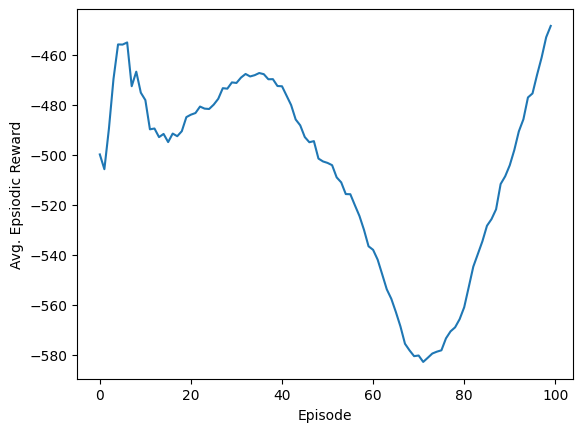

In [ ]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

   # prev_state = tf.squeeze(env.reset())
    prev_state = env.reset()
    #print("prev_state: ", prev_state)
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        #print("tf_prev_state: ", tf_prev_state)

        action = policy(tf_prev_state, ou_noise)
        
        
        # Recieve state and reward from environment.
        #state, reward, done = env.step(action, tf_prev_state)

        state, reward, done = env.step(action, prev_state)
        print("State : ",state, " Reward : ",reward, " Done : ",done)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        # buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state
    buffer.learn()

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
# Save the weights
actor_model.save_weights("SI_actor.h5")
critic_model.save_weights("SI_critic.h5")

target_actor.save_weights("SI_target_actor.h5")
target_critic.save_weights("SI_target_critic.h5")